In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sqlalchemy import create_engine, text
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from sqlalchemy import create_engine, text

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
signals_geo = gpd.read_file('../data/traffic_signals_geo.zip')

In [4]:
devices_geo = gpd.read_file('../data/intelligent_traffic_system_devices.zip')

In [5]:
accidents_geo = pd.read_csv('../data/traffic_accidents.csv')

C:\Users\MattM\AppData\Local\Temp\ipykernel_16836\3003402844.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_geo = pd.read_csv('../data/traffic_accidents.csv')


In [6]:
zipcodes = gpd.read_file('../data/CO_Zips.zip')

In [7]:
accidents_geo.head(2)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry
0,0,0,0,0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00.000000,NaN,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.05359803 39.66771315)
1,1,1,1,1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00.000000,NaN,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,6,2016,June,POINT (-105.01867125 39.72532008)


In [8]:
accidents_geo['first_occurrence_date'] = pd.to_datetime(accidents_geo['first_occurrence_date'], format='ISO8601')
accidents_geo['last_occurrence_date'] = pd.to_datetime(accidents_geo['last_occurrence_date'], format='ISO8601')
accidents_geo['reported_date'] = pd.to_datetime(accidents_geo['reported_date'], format='ISO8601')


In [9]:
accidents_geo = gpd.GeoDataFrame(accidents_geo, 
                           crs = signals_geo.crs, 
                           geometry = gpd.points_from_xy(accidents_geo['geo_lon'], accidents_geo['geo_lat']))

In [10]:
zipcodes = zipcodes.to_crs("epsg:4326") 

<Axes: >

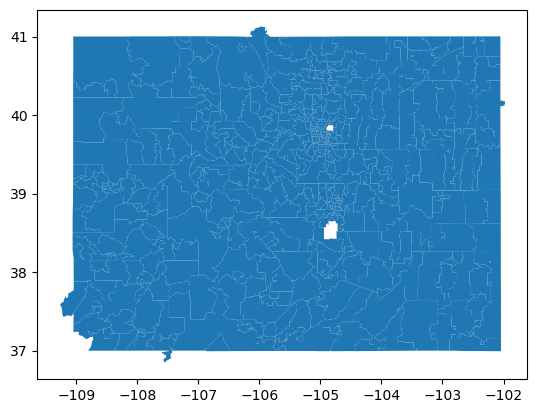

In [11]:
zipcodes.plot()

In [13]:
accidents_geo.head(2)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry
0,0,0,0,0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00,NaT,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.05360 39.66771)
1,1,1,1,1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00,NaT,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,6,2016,June,POINT (-105.01867 39.72532)


In [14]:
accidents_geo.top_traffic_accident_offense.value_counts()

top_traffic_accident_offense
TRAF - ACCIDENT                   163258
TRAF - ACCIDENT - HIT & RUN        72460
TRAF - ACCIDENT - DUI/DUID          6790
TRAF - ACCIDENT - SBI               3926
TRAF - ACCIDENT - POLICE            2438
TRAF - ACCIDENT - FATAL              685
Name: count, dtype: int64

#### Function/If Statement old way of doing things

In [15]:
# def set_type(type):
#     if type["top_traffic_accident_offense"].strip() == "TRAF - ACCIDENT":
#         return "ACCIDENT"
#     elif type["top_traffic_accident_offense"].strip() == "TRAF - ACCIDENT - HIT & RUN":
#         return "HIT & RUN"
#     elif type["top_traffic_accident_offense"].strip() == "TRAF - ACCIDENT - DUI/DUID":
#         return "DUI"
#     elif type["top_traffic_accident_offense"].strip() == "TRAF - ACCIDENT - SBI":
#         return "SBI"
#     elif type["top_traffic_accident_offense"].strip() == "TRAF - ACCIDENT - POLICE":
#         return "POLICE"
#     elif type["top_traffic_accident_offense"].strip() == "TRAF - ACCIDENT - FATAL":
#         return "FATAL"
#     else:
#         pass
    
# accidents_geo = accidents_geo.assign(offense=accidents_geo.apply(set_type, axis=1))

In [16]:
# accidents_geo[accidents_geo["top_traffic_accident_offense"].strip() == "TRAF - ACCIDENT - HIT & RUN"]

#### ---------------------------------------------------------------------------

#### For loop to create the column instead

In [17]:
x=[]
for value in accidents_geo['top_traffic_accident_offense']:
    x.append(value.split("-")[-1].strip())
#     print(value.split("-")[-1].strip())

In [18]:
accidents_geo['offense_clean'] = x

In [20]:
accidents_geo[accidents_geo['offense_clean'] == 'ACCIDENT']

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry,offense_clean
0,0,0,0,0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00,NaT,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.05360 39.66771),ACCIDENT
1,1,1,1,1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00,NaT,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,6,2016,June,POINT (-105.01867 39.72532),ACCIDENT
4,4,4,4,4,<geoprocessing describe geometry object object...,38436,2016585303,201658530354410,5441,0,TRAF - ACCIDENT,2016-09-12 10:00:00,NaT,2016-09-12 11:41:00.000000,W 49TH AVE / N FEDERAL BLVD,3133441.0,1711386.0,-105.025185,39.785605,1,111.0,Chaffee Park,0.0,0.0,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,STOPPED IN TRAFFIC,OTHER,OTHER,PASSENGER CAR/VAN,NORTH,GOING STRAIGHT,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.02519 39.78560),ACCIDENT
6,6,6,6,6,<geoprocessing describe geometry object object...,38438,2016420306,201642030654410,5441,0,TRAF - ACCIDENT,2016-07-03 23:15:00,NaT,2016-07-04 00:01:00.000000,E 6TH AVE / N FAIRFAX ST,3160803.0,1689693.0,-104.928313,39.725621,2,321.0,Hilltop,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,SUV,EAST,GOING STRAIGHT,FOLLOWED TOO CLOSELY,DISTRACTED PASSENGER,,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,7,2016,July,POINT (-104.92831 39.72562),ACCIDENT
7,7,7,7,7,<geoprocessing describe geometry object object...,38439,2016395400,201639540054410,5441,0,TRAF - ACCIDENT,2016-06-23 17:00:00,NaT,2016-06-23 18:25:00.000000,I225 HWYSB / S YOSEMITE ST,3173166.0,1658430.0,-104.885113,39.639576,3,324.0,Hampden South,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,NON INTERSECTION,STRAIGHT ON-LEVEL,WET,DAY LIGHT,PASSENGER CAR/VAN,SOUTH,GOING STRAIGHT,FOLLOWED TOO CLOSELY,DRIVER INEXPERIENCE,,PICKUP TRUCK/UTILITY VAN,SOUTH,STOPPED IN TRAFFIC,OTHER

In [27]:
accidents_geo['first_occurrence_date'] = pd.to_datetime(accidents_geo['first_occurrence_date'], format='ISO8601')
accidents_geo['last_occurrence_date'] = pd.to_datetime(accidents_geo['last_occurrence_date'], format='ISO8601')
accidents_geo['reported_date'] = pd.to_datetime(accidents_geo['reported_date'], format='ISO8601')
accidents_geo['month'] = accidents_geo['reported_date'].dt.month
accidents_geo['month_name'] = accidents_geo['reported_date'].dt.month_name()
accidents_geo['year'] = accidents_geo['reported_date'].dt.year
accidents_geo['day_name'] = accidents_geo['reported_date'].dt.day_name()
accidents_geo['hour'] = accidents_geo['reported_date'].dt.hour

In [34]:
accidents_geo.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry,offense_clean,day_name,hour,report_gap
0,0,0,0,0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00,NaT,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.05360 39.66771),ACCIDENT,Friday,20,3.0
1,1,1,1,1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00,NaT,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,6,2016,June,POINT (-105.01867 39.72532),ACCIDENT,Wednesday,15,0.0
2,2,2,2,2,<geoprocessing describe geometry object object...,38434,2016566651,201656665154010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-09-04 10:00:00,NaT,2016-09-04 12:48:00.000000,W COLFAX AVE / I25 HWYNB,3136682.0,1694949.0,-105.013966,39.740435,1,123.0,Lincoln Park,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,SUV,NORTHEAST,OTHER,17,OTHER,OTHER,SUV,NORTHEAST,SLOWING,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.01397 39.74044),HIT & RUN,Sunday,12,168.0
3,3,3,3,3,<geoprocessing describe geometry object object...,38435,2016771153,201677115354010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-12-03 08:00:00,NaT,2016-12-03 16:09:00.000001,5551 N WORCHESTER ST,3187975.0,1715553.0,-104.831037,39.796101,5,521.0,Montbello,0.0,0.0,PARKED MV WITH OTHER VEHICLE,,PARKED MV WITH OTHER VEHICLE,ON ROADWAY,NON INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,HIT AND RUN UNKNOWN,OTHER,OTHER,17,NO APPARENT,OTHER,PASSENGER CAR/VAN,OTHER,PARKED,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,12,2016,December,POINT (-104.83104 39.79610),HIT & RUN,Saturday,16,489.0
4,4,4,4,4,<geoprocessing describe geometry object object...,38436,2016585303,201658530354410,5441,0,TRAF - ACCIDENT,2016-09-12 10:00:00,NaT,2016-09-12 11:41:00.000000,W 49TH AVE / N FEDERAL BLVD,3133441.0,1711386.0,-105.025185,39.785605,1,111.0,Chaffee Park,0.0,0.0,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,STOPPED IN TRAFFIC,OTHER,OTHER,PASSENGER CAR/VAN,NORTH,GOING STRAIGHT,00,NO APPARENT,OTHER

In [33]:
accidents_geo['report_gap'] = (accidents_geo['reported_date'] - accidents_geo['first_occurrence_date']) / pd.Timedelta(minutes=1)

In [35]:
accidents_geo = accidents_geo.drop(columns=['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])
accidents_geo.head()

,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry,offense_clean,day_name,hour,report_gap
0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00,NaT,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.05360 39.66771),ACCIDENT,Friday,20,3.0
1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00,NaT,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,6,2016,June,POINT (-105.01867 39.72532),ACCIDENT,Wednesday,15,0.0
2,<geoprocessing describe geometry object object...,38434,2016566651,201656665154010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-09-04 10:00:00,NaT,2016-09-04 12:48:00.000000,W COLFAX AVE / I25 HWYNB,3136682.0,1694949.0,-105.013966,39.740435,1,123.0,Lincoln Park,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,SUV,NORTHEAST,OTHER,17,OTHER,OTHER,SUV,NORTHEAST,SLOWING,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.01397 39.74044),HIT & RUN,Sunday,12,168.0
3,<geoprocessing describe geometry object object...,38435,2016771153,201677115354010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-12-03 08:00:00,NaT,2016-12-03 16:09:00.000001,5551 N WORCHESTER ST,3187975.0,1715553.0,-104.831037,39.796101,5,521.0,Montbello,0.0,0.0,PARKED MV WITH OTHER VEHICLE,,PARKED MV WITH OTHER VEHICLE,ON ROADWAY,NON INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,HIT AND RUN UNKNOWN,OTHER,OTHER,17,NO APPARENT,OTHER,PASSENGER CAR/VAN,OTHER,PARKED,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,12,2016,December,POINT (-104.83104 39.79610),HIT & RUN,Saturday,16,489.0
4,<geoprocessing describe geometry object object...,38436,2016585303,201658530354410,5441,0,TRAF - ACCIDENT,2016-09-12 10:00:00,NaT,2016-09-12 11:41:00.000000,W 49TH AVE / N FEDERAL BLVD,3133441.0,1711386.0,-105.025185,39.785605,1,111.0,Chaffee Park,0.0,0.0,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,STOPPED IN TRAFFIC,OTHER,OTHER,PASSENGER CAR/VAN,NORTH,GOING STRAIGHT,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.02519 39.78560),ACCI

In [38]:
accidents_geo.object_id.nunique()

203617

In [39]:
accidents_geo.incident_id.nunique()

249549

In [40]:
accidents_geo.offense_id.nunique()

249550

In [43]:
accidents_geo['TU1_TRAVEL_DIRECTION'] = accidents_geo['TU1_TRAVEL_DIRECTION'].str.lower()

In [44]:
accidents_geo['TU1_TRAVEL_DIRECTION'].value_counts()

TU1_TRAVEL_DIRECTION
north                  62921
south                  56632
west                   49200
east                   49127
other                   6515
northwest               4672
southeast               4404
southwest               3706
northeast               3586
                        2145
under investigation      876
unk                        1
021                        1
91                         1
Name: count, dtype: int64

In [46]:
accidents_geo = gpd.sjoin(accidents_geo, zipcodes, predicate = 'within')

In [49]:
accidents_geo = accidents_geo.drop(columns=['index_right', 'OBJECTID', 'GEOID10'])
accidents_geo = accidents_geo.rename(columns = {'ZCTA5CE10' : 'zipcode'})
accidents_geo.head()

,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry,offense_clean,day_name,hour,report_gap,zipcode
0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00,NaT,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,east,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.05360 39.66771),ACCIDENT,Friday,20,3.0,80227
1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00,NaT,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,east,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,6,2016,June,POINT (-105.01867 39.72532),ACCIDENT,Wednesday,15,0.0,80204
2,<geoprocessing describe geometry object object...,38434,2016566651,201656665154010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-09-04 10:00:00,NaT,2016-09-04 12:48:00.000000,W COLFAX AVE / I25 HWYNB,3136682.0,1694949.0,-105.013966,39.740435,1,123.0,Lincoln Park,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,SUV,northeast,OTHER,17,OTHER,OTHER,SUV,NORTHEAST,SLOWING,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.01397 39.74044),HIT & RUN,Sunday,12,168.0,80204
3,<geoprocessing describe geometry object object...,38435,2016771153,201677115354010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-12-03 08:00:00,NaT,2016-12-03 16:09:00.000001,5551 N WORCHESTER ST,3187975.0,1715553.0,-104.831037,39.796101,5,521.0,Montbello,0.0,0.0,PARKED MV WITH OTHER VEHICLE,,PARKED MV WITH OTHER VEHICLE,ON ROADWAY,NON INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,HIT AND RUN UNKNOWN,other,OTHER,17,NO APPARENT,OTHER,PASSENGER CAR/VAN,OTHER,PARKED,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,12,2016,December,POINT (-104.83104 39.79610),HIT & RUN,Saturday,16,489.0,80239
4,<geoprocessing describe geometry object object...,38436,2016585303,201658530354410,5441,0,TRAF - ACCIDENT,2016-09-12 10:00:00,NaT,2016-09-12 11:41:00.000000,W 49TH AVE / N FEDERAL BLVD,3133441.0,1711386.0,-105.025185,39.785605,1,111.0,Chaffee Park,0.0,0.0,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,PASSENGER CAR/VAN,east,GOING STRAIGHT,STOPPED IN TRAFFIC,OTHER,OTHER,PASSENGER CAR/VAN,NORTH,GOING STRAIGHT,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,

In [52]:
accidents_geo[accidents_geo['zipcode'] == '80137']

,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry,offense_clean,day_name,hour,report_gap,zipcode
196060,<geoprocessing describe geometry object object...,73800,20238054863,2023805486354010,5401,0,TRAF - ACCIDENT - HIT & RUN,2023-10-03 06:47:00,2023-10-03 06:47:00,2023-10-03 08:10:00.000001,"LAT:39°50'24.00""N LONG:104°36'0.00""W 4000 BLK ...",3252735.0,1732104.0,-104.600000,39.839999,7,NaN,NaN,0.0,0.0,Side to Side-Same Direction,NaN,Side to Side-Same Direction,On Roadway,At Intersection,Straight - Level,Dry,Daylight,Passenger Car/Passenger Van,north,Going Straight,No Contributing Action,No Apparent Contributing Factor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10,2023,October,POINT (-104.60000 39.84000),HIT & RUN,Tuesday,8,83.0,80137
236832,<geoprocessing describe geometry object object...,25792,20168011144,2016801114454410,5441,0,TRAF - ACCIDENT,2016-03-21 10:15:00,NaT,2016-03-21 10:21:00.000000,31500 BLOCK E 96TH AVE,3247222.0,1743069.0,-104.619252,39.870246,7.0,759.0,DIA,0.0,0.0,TREE,,TREE,RAN OFF LEFT SIDE,NON INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,PICKUP TRUCK/UTILITY VAN,west,GOING STRAIGHT,EXCEED SAFE/POSTED SPEED,ILLNESS/MEDICAL,,,,,,,,0.0,0.0,,,,,NaN,NaN,3,2016,March,POINT (-104.61925 39.87025),ACCIDENT,Monday,10,6.0,80137


In [62]:
def get_season(x):
    if (x['month_name'] == "December" or x['month_name'] == "January" or x['month_name'] == "February" or x['month_name'] == "March"):
       return "WINTER"
    elif(x['month_name'] == "April" or x['month_name'] == "May"):
       return "SPRING"
    elif(x['month_name'] =="June" or x['month_name']=="July" or x['month_name'] == "August" or x['month_name'] == "September"):
       return "SUMMER"
    else:
       return "FALL"

accidents_geo = accidents_geo.assign(season=accidents_geo.apply(get_season, axis=1))

In [59]:
def get_season(month):
    if (['month_name'] == "December" or ['month_name'] == "January" or ['month_name'] == "February" or ['month_name'] == "March"):
       return "WINTER"
    elif(['month_name'] == "April" or ['month_name'] == "May"):
       return "SPRING"
    elif(['month_name'] =="June" or ['month_name']=="July" or ['month_name'] == "August" or ['month_name'] == "September"):
       return "SUMMER"
    else:
       return "FALL"

accidents_geo = accidents_geo.assign(season=accidents_geo.apply(get_season, axis=1))

In [63]:
accidents_geo.head()

,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,month,year,month_name,geometry,offense_clean,day_name,hour,report_gap,zipcode,season
0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00,NaT,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,east,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.05360 39.66771),ACCIDENT,Friday,20,3.0,80227,SUMMER
1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00,NaT,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,east,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN,6,2016,June,POINT (-105.01867 39.72532),ACCIDENT,Wednesday,15,0.0,80204,SUMMER
2,<geoprocessing describe geometry object object...,38434,2016566651,201656665154010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-09-04 10:00:00,NaT,2016-09-04 12:48:00.000000,W COLFAX AVE / I25 HWYNB,3136682.0,1694949.0,-105.013966,39.740435,1,123.0,Lincoln Park,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,SUV,northeast,OTHER,17,OTHER,OTHER,SUV,NORTHEAST,SLOWING,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,9,2016,September,POINT (-105.01397 39.74044),HIT & RUN,Sunday,12,168.0,80204,SUMMER
3,<geoprocessing describe geometry object object...,38435,2016771153,201677115354010,5401,0,TRAF - ACCIDENT - HIT & RUN,2016-12-03 08:00:00,NaT,2016-12-03 16:09:00.000001,5551 N WORCHESTER ST,3187975.0,1715553.0,-104.831037,39.796101,5,521.0,Montbello,0.0,0.0,PARKED MV WITH OTHER VEHICLE,,PARKED MV WITH OTHER VEHICLE,ON ROADWAY,NON INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,HIT AND RUN UNKNOWN,other,OTHER,17,NO APPARENT,OTHER,PASSENGER CAR/VAN,OTHER,PARKED,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN,12,2016,December,POINT (-104.83104 39.79610),HIT & RUN,Saturday,16,489.0,80239,WINTER
4,<geoprocessing describe geometry object object...,38436,2016585303,201658530354410,5441,0,TRAF - ACCIDENT,2016-09-12 10:00:00,NaT,2016-09-12 11:41:00.000000,W 49TH AVE / N FEDERAL BLVD,3133441.0,1711386.0,-105.025185,39.785605,1,111.0,Chaffee Park,0.0,0.0,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,FRONT TO SIDE WITH MV IN TRANSPORT,ON ROADWAY,AT INTERSECTION,STRAIGHT ON-LEVEL,DRY,DAY LIGHT,PASSENGER CAR/VAN,east,GOING STRAIGHT,STOPPED IN TRAFFIC,OTHER,OTHER,PASSENGER CAR/VAN,NORTH,GOING STRAIGHT,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OT

In [68]:
signals_geo.head()

,TRAFFIC_SI,RECORD_DAT,RECORD_STA,SIGNAL_STA,FROM_DATE,TO_DATE,SIGNAL_OWN,LOCATION_C,LOCATION_I,SIGNAL_TYP,INSTALLATI,REBUILD_DA,MAJOR_RETI,geometry,lon,lat
0,171,2012-01-09,ACTIVE,IN USE,2012-01-01,None,CCD,4422,658,None,None,None,None,POINT (-105.00081 39.74669),-105.000805,39.746685
1,172,2012-01-09,ACTIVE,IN USE,2012-01-01,None,CCD,3085,63,None,None,None,None,POINT (-105.00142 39.74641),-105.001422,39.746413
2,173,2012-01-09,ACTIVE,IN USE,2012-01-01,None,CCD,4020,504,None,None,None,None,POINT (-104.99404 39.72893),-104.994036,39.728930
3,174,2012-01-09,ACTIVE,IN USE,2012-01-01,None,CCD,3292N,213,None,None,None,None,POINT (-105.00018 39.72892),-105.000176,39.728925
4,176,2012-01-09,ACTIVE,IN USE,2012-01-01,None,CCD,3975,489,None,None,None,None,POINT (-104.98038 39.71112),-104.980383,39.711119


In [67]:
signals_geo['lon'] = signals_geo['geometry'].x
signals_geo['lat'] = signals_geo['geometry'].y

In [69]:
signals_geo.to_csv('../data/traffic_signals_geo.csv')
devices_geo.to_csv('../data/intelligent_traffic_system_devices.csv')
accidents_geo.to_csv('../data/traffic_accidents.csv')